In [7]:
import matplotlib.pyplot as plt
from baseline.baseline_rag import VideoRAGBaseline
from baseline.vlm_answerer import VLMAnswerer
from baseline.video_utils import load_video_mme_dataset, get_short_visual_samples, extract_frames_at_fps, create_chunks
from data.video_manager import VideoManager
import numpy as np
from PIL import Image

In [3]:
# Load sample
dataset = load_video_mme_dataset()
samples = get_short_visual_samples(dataset, n_samples=5)
sample = samples[0]

# Get video
video_manager = VideoManager()
video_path = video_manager.get_video(sample['youtube_id'])

Using cached video: data/fFjv93ACGo8.mp4


Extracted 77 frames from data/fFjv93ACGo8.mp4
Total frames: 77


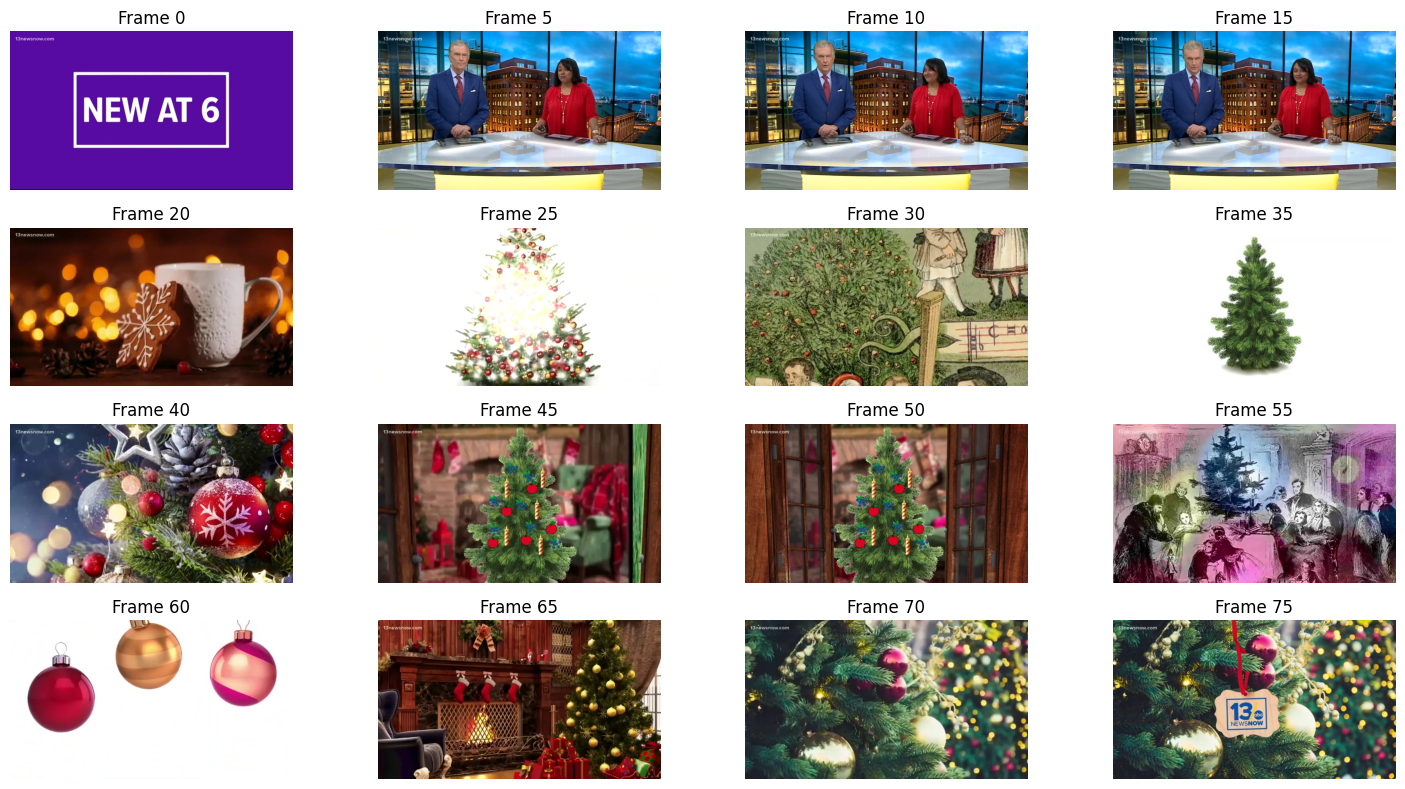

In [5]:
# Extract and visualize frames
frames = extract_frames_at_fps(video_path, fps=1)
print(f"Total frames: {len(frames)}")

# Show every 5th frame to see temporal coverage
fig, axes = plt.subplots(4, 4, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    frame_idx = i * 5
    if frame_idx < len(frames):
        ax.imshow(frames[frame_idx])
        ax.set_title(f"Frame {frame_idx}")
        ax.axis('off')
plt.tight_layout()
plt.show()

Using device: cuda


/home/brend/vlm-context-engineering/venv/lib/python3.10/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Processing video: data/fFjv93ACGo8.mp4
Query: When demonstrating the Germany modern Christmas tree is initially decorated with apples, candles and berries, which kind of the decoration has the largest number?
Extracted 77 frames from data/fFjv93ACGo8.mp4
Created 26 chunks
Top similarities: [0.30884218 0.303685   0.30157435]

Question: When demonstrating the Germany modern Christmas tree is initially decorated with apples, candles and berries, which kind of the decoration has the largest number?
Top-K similarities: [0.30884218 0.303685   0.30157435]


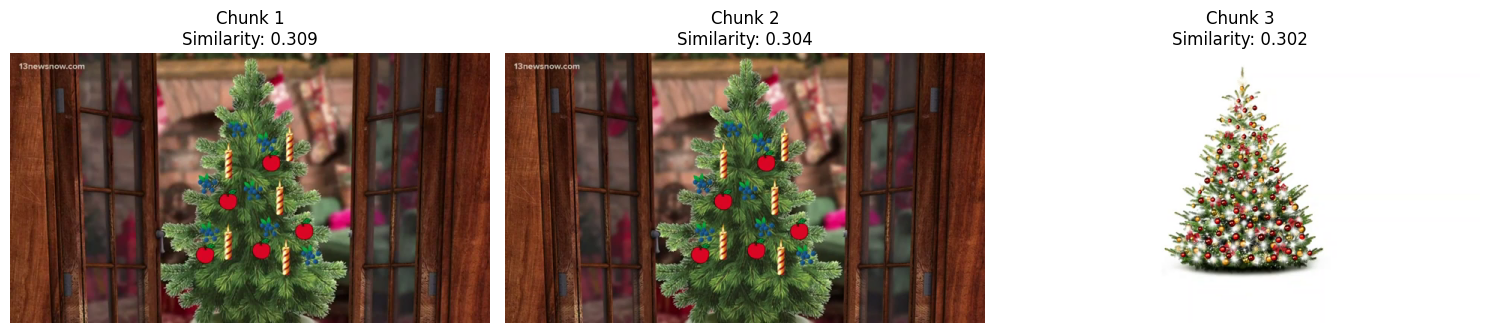

In [6]:
# Now show the top-K retrieved chunks
rag = VideoRAGBaseline()
question = sample['question']
chunks, similarities = rag.process_video(video_path, question, k=3)

print(f"\nQuestion: {question}")
print(f"Top-K similarities: {similarities}")

# Visualize the retrieved chunks (middle frame from each)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (chunk, sim) in enumerate(zip(chunks, similarities)):
    mid_frame = chunk[len(chunk)//2]
    axes[i].imshow(mid_frame)
    axes[i].set_title(f"Chunk {i+1}\nSimilarity: {sim:.3f}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

VLM receives 3 frames


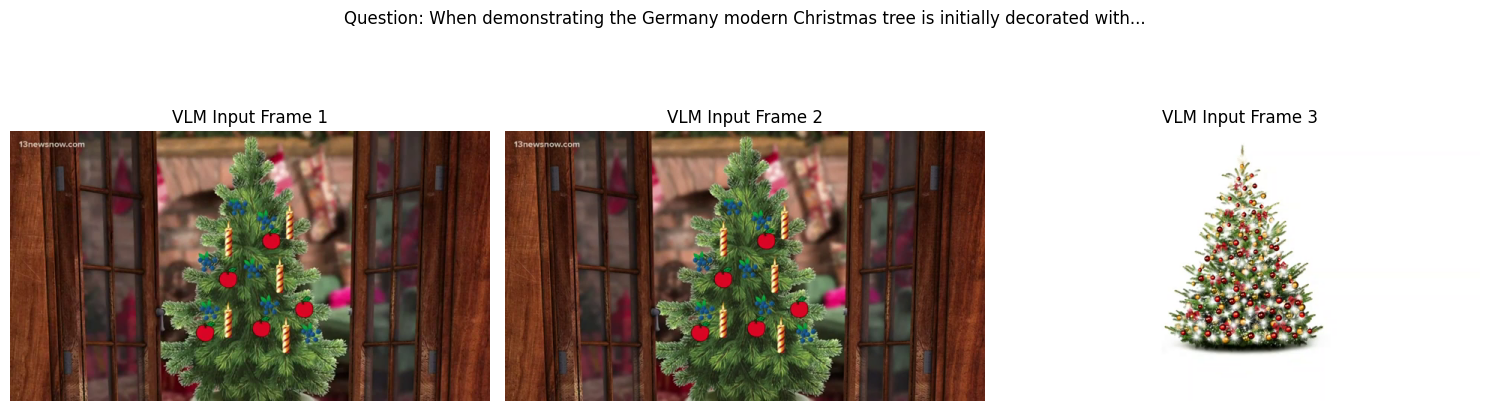

In [8]:
# Inspect what the VLM actually receives

# Get the frames that will be sent to VLM (middle frame from each chunk)
vlm_input_frames = []
for chunk in chunks:
    mid_idx = len(chunk) // 2
    vlm_input_frames.append(chunk[mid_idx])

print(f"VLM receives {len(vlm_input_frames)} frames")

# Visualize what VLM sees
fig, axes = plt.subplots(1, len(vlm_input_frames), figsize=(15, 5))
if len(vlm_input_frames) == 1:
    axes = [axes]
for i, frame in enumerate(vlm_input_frames):
    axes[i].imshow(frame)
    axes[i].set_title(f"VLM Input Frame {i+1}")
    axes[i].axis('off')
plt.suptitle(f"Question: {question[:80]}...")
plt.tight_layout()
plt.show()

In [9]:
# Show the full prompt text
options_text = "\n".join(sample['options'])
full_prompt = f"{question}\n\n{options_text}\n\nAnswer with only the letter (A, B, C, or D):"
print("\n=== VLM Text Prompt ===")
print(full_prompt)
print("=" * 50)


=== VLM Text Prompt ===
When demonstrating the Germany modern Christmas tree is initially decorated with apples, candles and berries, which kind of the decoration has the largest number?

A. Apples.
B. Candles.
C. Berries.
D. The three kinds are of the same number.

Answer with only the letter (A, B, C, or D):


In [10]:
# Get VLM prediction
vlm = VLMAnswerer()
predicted_answer = vlm.answer_question(chunks, question, sample['options'])

print(f"\nPredicted: {predicted_answer}")
print(f"Correct: {sample['answer']}")
print(f"Match: {predicted_answer == sample['answer']}")

Loading VLM: Qwen/Qwen2.5-VL-7B-Instruct


Loading checkpoint shards: 100%|██████████| 5/5 [01:09<00:00, 13.91s/it]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


VLM loaded on cuda


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


VLM raw output: C

Predicted: C
Correct: C
Match: True


In [11]:
import torch

def print_gpu_memory():
    print(f"GPU Memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB allocated")
    print(f"GPU Memory: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB reserved")

print_gpu_memory()

GPU Memory: 11.97 GB allocated
GPU Memory: 13.11 GB reserved


In [12]:
# Get all questions for this video across visual task types
video_id = sample['video_id']
visual_tasks = [
    "Counting Problem", 
    "Information Synopsis", 
    "Spatial Relationship",
    "Visual Recognition",
    "Action Recognition"
]

# Filter dataset for this specific video
video_questions = []
for item in dataset:
    if (item['video_id'] == video_id and 
        item['duration'] == 'short' and 
        item['task_type'] in visual_tasks):
        video_questions.append({
            'question_id': item['question_id'],
            'question': item['question'],
            'options': item['options'],
            'answer': item['answer'],
            'task_type': item['task_type']
        })

print(f"Found {len(video_questions)} questions for video {video_id}")

Found 3 questions for video 001


In [13]:
results = []
for i, qa in enumerate(video_questions):
    print(f"\n{'='*60}")
    print(f"Question {i+1}/{len(video_questions)} - {qa['task_type']}")
    print(f"{'='*60}")
    
    # Retrieve relevant chunks for this question
    chunks, similarities = rag.process_video(video_path, qa['question'], k=3)
    
    print(f"Q: {qa['question']}")
    print(f"Options: {qa['options']}")
    
    # Get VLM prediction
    predicted = vlm.answer_question(chunks, qa['question'], qa['options'])
    correct = qa['answer']
    
    is_correct = predicted == correct
    results.append({
        'question_id': qa['question_id'],
        'task_type': qa['task_type'],
        'predicted': predicted,
        'correct': correct,
        'is_correct': is_correct,
        'top_similarity': similarities[0] if len(similarities) > 0 else 0
    })
    
    print(f"Predicted: {predicted} | Correct: {correct} | {'✓' if is_correct else '✗'}")


Question 1/3 - Counting Problem
Processing video: data/fFjv93ACGo8.mp4
Query: When demonstrating the Germany modern Christmas tree is initially decorated with apples, candles and berries, which kind of the decoration has the largest number?
Extracted 77 frames from data/fFjv93ACGo8.mp4
Created 26 chunks
Top similarities: [0.30884218 0.303685   0.30157435]
Q: When demonstrating the Germany modern Christmas tree is initially decorated with apples, candles and berries, which kind of the decoration has the largest number?
Options: ['A. Apples.', 'B. Candles.', 'C. Berries.', 'D. The three kinds are of the same number.']
VLM raw output: C
Predicted: C | Correct: C | ✓

Question 2/3 - Information Synopsis
Processing video: data/fFjv93ACGo8.mp4
Query: What is the genre of this video?
Extracted 77 frames from data/fFjv93ACGo8.mp4
Created 26 chunks
Top similarities: [0.23520118 0.22932477 0.2270629 ]
Q: What is the genre of this video?
Options: ['A. It is a news report that introduces the hist